# Understand dataset

In [1]:
#Import Libraries

#General
import numpy 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import itertools

#SK-Learn
from sklearn import svm, metrics, neighbors, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#Catboost
from catboost import CatBoostClassifier

In [2]:
#Load Training Data

training_data = 'algebra_2008_2009_train.txt'
df = pd.read_table(training_data)
print('Loading... Done!')

Loading... Done!


Now let's check the gist of the training data. 

In [3]:
df.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Correct First Attempt,Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules)
0,1,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R2C1,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,...,0,3,1,1,Identifying units,1,NaN,NaN,UNIT-HELP,1
1,2,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C1,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,...,1,0,0,1,Define Variable,1,NaN,NaN,VARIABLE-HELP,1
2,3,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C2,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,...,1,0,0,1,"Write expression, any form~~Using simple numbe...",1~~1~~1~~1~~1~~1,Using simple numbers-1~~Using large numbers-1~...,1~~1~~1,STANDARD-MX+B-FORMULA-HELP,1
3,4,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C1,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,...,1,1,0,1,"Entering a given~~Enter given, reading words~~...",1~~1~~1,Entering a given-1,1,GIVEN-HELP-NON-NUMERIC-PHRASE,1
4,5,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C2,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,2008-09-19 13:30:46.0,...,1,0,0,1,"Using simple numbers~~Find Y, any form~~Using ...",2~~1~~2~~1,Using simple numbers-1~~Using large numbers-1~...,2~~2~~1,CALCULATED-VALUE-HELP-MX+B-GIVEN-X-ZERO,1


Looks like some of the features are hidden in the summary. Let's check their properties too. (Step Duration, Correct Step Duration, Error Step Duration)

In [4]:
df["Step Duration (sec)"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Step Duration (sec), dtype: float64

In [5]:
df["Correct Step Duration (sec)"].head()

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: Correct Step Duration (sec), dtype: float64

In [6]:
df["Error Step Duration (sec)"].head()

0    0.0
1    NaN
2    NaN
3    NaN
4    NaN
Name: Error Step Duration (sec), dtype: float64

# Feature Analysis and Selection

In [7]:
# Let's find all columns that have Null vales (NaN)
df.isnull().sum()

Row                                  0
Anon Student Id                      0
Problem Hierarchy                    0
Problem Name                         0
Problem View                         0
Step Name                            0
Step Start Time                 265516
First Transaction Time               0
Correct Transaction Time        238090
Step End Time                        0
Step Duration (sec)             442921
Correct Step Duration (sec)    1641028
Error Step Duration (sec)      7719947
Correct First Attempt                0
Incorrects                           0
Hints                                0
Corrects                             0
KC(SubSkills)                  2475917
Opportunity(SubSkills)         2475917
KC(KTracedSkills)              4498349
Opportunity(KTracedSkills)     4498349
KC(Rules)                       322051
Opportunity(Rules)              322051
dtype: int64

In [8]:
# Step Start Time is basically timestamp of data, needs to be converted into Datetime format

df['Step Start Time'] = pd.Series(pd.to_datetime(df['Step Start Time']))

# Similarly let's convert First Transaction Time and Step End Time (As they aren't null)

df['First Transaction Time'] = pd.Series(pd.to_datetime(df['First Transaction Time']))
df['Step End Time'] = pd.Series(pd.to_datetime(df['Step End Time']))

Now we can replace the null values with the first Timestap of data being recorded. 

In [9]:
df.sort_values('Step Start Time', axis=0, ascending=True).head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Correct First Attempt,Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules)
7680763,7680764,stu_b4581374fd,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-030,1,Numerator,2008-09-06 21:32:28,2008-09-06 21:32:28,2008-09-06 21:32:28.0,2008-09-06 21:32:28,...,1,0,0,1,Enter numerator of converted unit,1,NaN,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HIN...,1
7680760,7680761,stu_b4581374fd,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-030,1,MoreOrFewer,2008-09-06 21:32:28,2008-09-06 21:32:28,2008-09-06 21:32:28.0,2008-09-06 21:32:28,...,1,0,0,1,Compare units,1,Compare units-1,1,UNIT-CONVERSION-RELATIVE-SIZE-GOAL-NODE-Condit...,1
7680761,7680762,stu_b4581374fd,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-030,1,ConversionFactorpoundsounces,2008-09-06 21:32:28,2008-09-06 21:32:28,2008-09-06 21:32:28.0,2008-09-06 21:32:28,...,0,1,2,1,Enter unit conversion,1,Enter unit conversion-1,1,UNIT-CONVERSION-CONVERSION-FACTOR-GOAL-NODE-Co...,1
7680762,7680763,stu_b4581374fd,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-030,1,SelectFractionpoundsounces,2008-09-06 21:32:28,2008-09-06 21:32:28,2008-09-06 21:32:28.0,2008-09-06 21:32:28,...,1,0,0,1,Select form of one with denominator of one,1,Select form of one with denominator of one-1,1,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...,1
7680764,7680765,stu_b4581374fd,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-030,1,Denominator,2008-09-06 21:32:28,2008-09-06 21:32:28,2008-09-06 21:32:28.0,2008-09-06 21:32:28,...,1,0,0,1,Enter denominator of converted unit,1,NaN,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HIN...,2


In [10]:
# Replace NaN with first Timestamp value

df['Step Start Time'] = df['Step Start Time'].apply(lambda val: val if not pd.isnull(val) else pd.to_datetime('2008-09-06 21:32:28'))

In [11]:
# Similarly for Step Duration, Correct Step Duration, Error Step Duration as it is recorded only in seconds.

df['Step Duration (sec)'] = df['Step Duration (sec)'].fillna(0)
df['Correct Step Duration (sec)'] = df['Correct Step Duration (sec)'].fillna(0)
df['Error Step Duration (sec)'] = df['Error Step Duration (sec)'].fillna(0)

In [12]:
# (Depends on "Corrects" value. When "Corrects" value is 0, it's obvious this feature gets NaN), 
# Therefore we can assign datetime of a standard. Reduces data errors.

df['Correct Transaction Time'] = df['Correct Transaction Time'].apply(lambda x: x if not pd.isnull(x) else pd.to_datetime('2008-01-01 00:00:00'))

In [13]:
# The features Opportunity(Rules), Opportunity(KTracedSkills), Opportunity(SubSkills) are numerical. 
# Therefore fill NaN with 1
# For more info, check Data Format at PSLC DataShop website. It talks more about Opportunity and KC (Knowledge Component)

df['Opportunity(Rules)'] = df['Opportunity(Rules)'].fillna(1)
df['Opportunity(KTracedSkills)'] = df['Opportunity(KTracedSkills)'].fillna(1)
df['Opportunity(SubSkills)'] = df['Opportunity(SubSkills)'].fillna(1)

In [14]:
# The features KC(Rules), KC(KTracedSkills), KC(SubSkills) are text based values. 
# Therefore fill NaN with COMMON

df['KC(Rules)'] = df['KC(Rules)'].fillna("COMMON")
df['KC(KTracedSkills)'] = df['KC(KTracedSkills)'].fillna("COMMON")
df['KC(SubSkills)'] = df['KC(SubSkills)'].fillna("COMMON")

Now let's see if there are any NaN values left for the features. :) 

In [15]:
df.isnull().sum()

Row                            0
Anon Student Id                0
Problem Hierarchy              0
Problem Name                   0
Problem View                   0
Step Name                      0
Step Start Time                0
First Transaction Time         0
Correct Transaction Time       0
Step End Time                  0
Step Duration (sec)            0
Correct Step Duration (sec)    0
Error Step Duration (sec)      0
Correct First Attempt          0
Incorrects                     0
Hints                          0
Corrects                       0
KC(SubSkills)                  0
Opportunity(SubSkills)         0
KC(KTracedSkills)              0
Opportunity(KTracedSkills)     0
KC(Rules)                      0
Opportunity(Rules)             0
dtype: int64

The aim of the project is to predict the number of first attempts correctly. Therefore focus is now on a feature called '<b>Correct First Attempt</b>' (CFA). So now let's go ahead playing around with the context of CFA! 

Finally we aim to create a new feature called '<b>Correct First Attempt Rate</b>' (CFAR) and merge it into existing DF. :)

In [16]:
cfa_df_1 = df.groupby(['Anon Student Id','Correct First Attempt'], as_index=False).count()

In [17]:
cfa_df_1.head()

,Anon Student Id,Correct First Attempt,Row,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,...,Error Step Duration (sec),Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules)
0,stu_000d56dbbb,0,789,789,789,789,789,789,789,789,...,789,789,789,789,789,789,789,789,789,789
1,stu_000d56dbbb,1,5395,5395,5395,5395,5395,5395,5395,5395,...,5395,5395,5395,5395,5395,5395,5395,5395,5395,5395
2,stu_0018382601,0,1089,1089,1089,1089,1089,1089,1089,1089,...,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
3,stu_0018382601,1,4624,4624,4624,4624,4624,4624,4624,4624,...,4624,4624,4624,4624,4624,4624,4624,4624,4624,4624
4,stu_002821e04e,0,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33


In [18]:
cfa_df_1 = cfa_df_1.loc[:, ['Anon Student Id','Correct First Attempt', 'Row']]
cfa_df_1.head()

,Anon Student Id,Correct First Attempt,Row
0,stu_000d56dbbb,0,789
1,stu_000d56dbbb,1,5395
2,stu_0018382601,0,1089
3,stu_0018382601,1,4624
4,stu_002821e04e,0,33


In [19]:
cfa_df_2 = df.groupby(['Anon Student Id'], as_index=False).count()
cfa_df_2 = cfa_df_2.loc[:, ['Anon Student Id', 'Row']]
cfa_df_2.head()

,Anon Student Id,Row
0,stu_000d56dbbb,6184
1,stu_0018382601,5713
2,stu_002821e04e,212
3,stu_003f10a343,2035
4,stu_004a3f900a,1213


In [20]:
cfa_df = cfa_df_1.merge(cfa_df_2, left_on=['Anon Student Id'], right_on=['Anon Student Id'], how='left')
cfa_df.head()

,Anon Student Id,Correct First Attempt,Row_x,Row_y
0,stu_000d56dbbb,0,789,6184
1,stu_000d56dbbb,1,5395,6184
2,stu_0018382601,0,1089,5713
3,stu_0018382601,1,4624,5713
4,stu_002821e04e,0,33,212


In [21]:
cfa_df = cfa_df[cfa_df['Correct First Attempt'] == 1]
cfa_df.head()

# Row_x corresponds to Students' total correct count 
# Row_y corresponds to Students' total attempt count

,Anon Student Id,Correct First Attempt,Row_x,Row_y
1,stu_000d56dbbb,1,5395,6184
3,stu_0018382601,1,4624,5713
5,stu_002821e04e,1,179,212
7,stu_003f10a343,1,1712,2035
9,stu_004a3f900a,1,1012,1213


In [22]:
cfa_df['CFAR'] = cfa_df['Row_x'] / cfa_df['Row_y']
cfa_df.head()

,Anon Student Id,Correct First Attempt,Row_x,Row_y,CFAR
1,stu_000d56dbbb,1,5395,6184,0.872413
3,stu_0018382601,1,4624,5713,0.809382
5,stu_002821e04e,1,179,212,0.844340
7,stu_003f10a343,1,1712,2035,0.841278
9,stu_004a3f900a,1,1012,1213,0.834295


In [23]:
cfa_df = cfa_df.loc[:, ['Anon Student Id', 'CFAR']]
df = df.merge(cfa_df, left_on=['Anon Student Id'], right_on=['Anon Student Id'], how='left')
df.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules),CFAR
0,1,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R2C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,3,1,1,Identifying units,1,COMMON,1,UNIT-HELP,1,0.889209
1,2,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,Define Variable,1,COMMON,1,VARIABLE-HELP,1,0.889209
2,3,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C2,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,"Write expression, any form~~Using simple numbe...",1~~1~~1~~1~~1~~1,Using simple numbers-1~~Using large numbers-1~...,1~~1~~1,STANDARD-MX+B-FORMULA-HELP,1,0.889209
3,4,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,1,0,1,"Entering a given~~Enter given, reading words~~...",1~~1~~1,Entering a given-1,1,GIVEN-HELP-NON-NUMERIC-PHRASE,1,0.889209
4,5,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C2,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,"Using simple numbers~~Find Y, any form~~Using ...",2~~1~~2~~1,Using simple numbers-1~~Using large numbers-1~...,2~~2~~1,CALCULATED-VALUE-HELP-MX+B-GIVEN-X-ZERO,1,0.889209


Engineered feature CFAR is added. Yay! :D 

In [24]:
# Now let's save our DF training file as Hierarchical Data Format (HDF)
# This is done for further feature engineering (One-Hot Encoding and Clustering)

df.to_hdf('training_data.hdf','data',mode='w') 

/Users/sb/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['Anon Student Id', 'Problem Hierarchy', 'Problem Name', 'Step Name', 'Correct Transaction Time', 'KC(SubSkills)', 'Opportunity(SubSkills)', 'KC(KTracedSkills)', 'Opportunity(KTracedSkills)', 'KC(Rules)', 'Opportunity(Rules)']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Let's focus on <b>One-Hot Encoding</b>, followed by <b>clustering</b> :)

In [25]:
df = pd.read_hdf('training_data.hdf','data')
print('Loading... Done!')

Loading... Done!


Let's explore 'Opportunity' and 'KC' features as their data patterns are different. 

In [26]:
df['Opportunity(SubSkills)'].unique()

array(['1', '1~~1~~1~~1~~1~~1', '1~~1~~1', ..., '186~~439~~374',
       '430~~426~~113', '187~~440~~375'], dtype=object)

In [27]:
df['Opportunity(KTracedSkills)'].unique()

array([1, '1~~1~~1', '1', ..., '59~~94', '62~~97', '6~~91'], dtype=object)

In [28]:
df['Opportunity(Rules)'].unique()

array(['1', '2', '3', ..., '9~~104', '10~~106', '55~~3~~1~~1'],
      dtype=object)

In [29]:
df['KC(SubSkills)'].unique()

array(['Identifying units', 'Define Variable',
       'Write expression, any form~~Using simple numbers~~Using large numbers~~Write expression, positive intercept~~Write expression, negative slope~~Write Expression, mx+b',
       ...,
       'Write expression, negative intercept~~Using small numbers~~Using difficult numbers~~Write Expression, mx+b~~Write expression, any form~~Write expression, negative slope',
       'Excluding the line when shading~~Shading less than',
       '[SkillRule: Remove constant; {ax+b=c, positive; ax+b=c, negative; x+a=b, positive; x+a=b, negative; [var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[const expr]=[const expr], all; Combine constants to right; Combine constants to left; a-x=b, positive; a/x+b=c, positive; a/x+b=c, negative}]~~[SkillRule: Isolate variable term in linear equation; {[var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[con

In [30]:
df['KC(KTracedSkills)'].unique()

array(['COMMON',
       'Using simple numbers-1~~Using large numbers-1~~Write expression, negative slope-1',
       'Entering a given-1',
       'Using simple numbers-1~~Using large numbers-1~~Find Y, negative slope-1',
       'Compare units-1', 'Enter unit conversion-1',
       'Select form of one with numerator of one-1',
       'Convert linear units-1~~Convert integer units-1',
       'Select form of one with denominator of one-1',
       'Convert linear units-1~~Convert decimal units less than one-1',
       'Convert integer units-1~~Convert volume units-1',
       'Convert linear units-1~~Convert decimal units greater than one-1',
       'Convert integer units-1~~Convert area units-1',
       'Convert decimal units less than one-1~~Convert linear units-1',
       'Convert volume units-1~~Convert decimal units greater than one-1',
       'Identifying units-1',
       'Using small numbers-1~~Using simple numbers-1~~Write expression, positive slope-1',
       'Using small numbers-1~~

In [31]:
df['KC(Rules)'].unique()

array(['UNIT-HELP', 'VARIABLE-HELP', 'STANDARD-MX+B-FORMULA-HELP', ...,
       '[Rule: MT no fraction coeff ([SolverOperation mt],)]~~[Rule: manipulate wrong side (null,{constant side expression})]~~[Rule: MT no fraction coeff (null,right)]~~[Rule: rf before mt ([SolverOperation rf],null)]',
       '[Rule: RF left, move neg. to numerator ([SolverOperation rf],{components with property canReduceFractionsNoMultWhole of left})]~~[Rule: multiply negative coeff ([SolverOperation multiply],{negative of reciprocal of coefficient of item 1 of variable terms of variable side expression})]',
       '[Rule: ax+b=cx+d, pos ([SolverOperation subtract],{item 1 of variable terms of left side})]~~[Rule: add positive term ([SolverOperation add],{item 1 of constant terms of variable side expression})]'],
      dtype=object)

In [32]:
# Data Wrangling to save memory space and consistency. Replacing '~~' with '~' as they aren't consistent across.

df['Opportunity(SubSkills)'] = df['Opportunity(SubSkills)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))
df['Opportunity(KTracedSkills)'] = df['Opportunity(KTracedSkills)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))
df['Opportunity(Rules)'] = df['Opportunity(Rules)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))
df['KC(SubSkills)'] = df['KC(SubSkills)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))
df['KC(KTracedSkills)'] = df['KC(KTracedSkills)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))
df['KC(Rules)'] = df['KC(Rules)'].apply(lambda x: x if "~" not in str(x) else x.replace('~~','~'))

In [33]:
df.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules),CFAR
0,1,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R2C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,3,1,1,Identifying units,1,COMMON,1,UNIT-HELP,1,0.889209
1,2,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,Define Variable,1,COMMON,1,VARIABLE-HELP,1,0.889209
2,3,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R3C2,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,"Write expression, any form~Using simple number...",1~1~1~1~1~1,Using simple numbers-1~Using large numbers-1~W...,1~1~1,STANDARD-MX+B-FORMULA-HELP,1,0.889209
3,4,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C1,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,1,0,1,"Entering a given~Enter given, reading words~En...",1~1~1,Entering a given-1,1,GIVEN-HELP-NON-NUMERIC-PHRASE,1,0.889209
4,5,stu_de2777346f,"Unit CTA1_01, Section CTA1_01-3",REAL20B,1,R4C2,2008-09-19 13:30:46,2008-09-19 13:30:46,2008-09-19 13:30:46.0,2008-09-19 13:30:46,...,0,0,1,"Using simple numbers~Find Y, any form~Using la...",2~1~2~1,Using simple numbers-1~Using large numbers-1~F...,2~2~1,CALCULATED-VALUE-HELP-MX+B-GIVEN-X-ZERO,1,0.889209


In [34]:
# One-Hot Encoding on Anon Student Id feature. 

stu_id_df = df['Anon Student Id'].unique()
stu_id_df

array(['stu_de2777346f', 'stu_b08a3605ac', 'stu_f3cd0a315f', ...,
       'stu_e2e1cce3c4', 'stu_244b6a9fdd', 'stu_6af5d5e304'], dtype=object)

In [35]:
stu_id_dict = dict(enumerate(stu_id_df))
stu_id_dict = {v: k for k, v in stu_id_dict.items()}
stu_id_dict

{'stu_de2777346f': 0,
 'stu_b08a3605ac': 1,
 'stu_f3cd0a315f': 2,
 'stu_cfb96da1cc': 3,
 'stu_e24aa8c101': 4,
 'stu_29de16cb51': 5,
 'stu_3da864f9c7': 6,
 'stu_7a4c314585': 7,
 'stu_b082c157c5': 8,
 'stu_948dbd21fd': 9,
 'stu_d40421e984': 10,
 'stu_d69d4f04e0': 11,
 'stu_470623952c': 12,
 'stu_e41db96ccd': 13,
 'stu_a20a6551e5': 14,
 'stu_c0c538f7e8': 15,
 'stu_3045559e59': 16,
 'stu_0142fbb2a7': 17,
 'stu_636f6e1ba4': 18,
 'stu_7c87107804': 19,
 'stu_e2a459ce90': 20,
 'stu_d3f3938302': 21,
 'stu_8099339ed4': 22,
 'stu_7453edd269': 23,
 'stu_e0cfbb5f61': 24,
 'stu_7a0fc0aab3': 25,
 'stu_1346115f12': 26,
 'stu_94b8f9bc86': 27,
 'stu_dde85a3a6a': 28,
 'stu_79061638bf': 29,
 'stu_ffb64665c3': 30,
 'stu_cfe8cd60cd': 31,
 'stu_befce87cd1': 32,
 'stu_8857af329a': 33,
 'stu_c9bd49579c': 34,
 'stu_41b3ea9077': 35,
 'stu_1e5b9da97f': 36,
 'stu_af364eb7cb': 37,
 'stu_e9983c110d': 38,
 'stu_4be4c74a63': 39,
 'stu_6be73bc2c2': 40,
 'stu_5e8ffe11c0': 41,
 'stu_129353eed5': 42,
 'stu_c84b293e94': 43

In [36]:
# Create a Pickle file for this Student ID feature dictionary.

with open('stu_id_dict.pickle', 'wb') as handle:
    pickle.dump(stu_id_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# Wrap up One-Hot Encoding on Anon Student Id feature. 

df['Anon Student Id'] = df['Anon Student Id'].apply(lambda x: stu_id_dict[x] if x in stu_id_dict else -1)

In [38]:
# Simarly let's apply One-Hot encoding for other features -- 'Problem Hierarchy', 'Problem Name', 'Step Name', 
# 'KC(Sub Skills)', 'KC(KTracedSkills)', 'KC(Rules)', 'Opportunity(SubSkills)', 'Opportunity(KTracedSkills)', 
# 'Opportunity(Rules)' 

def one_hot_encoding(feature) :
    feature_dict = df[feature].unique()
    feature_dict = dict(enumerate(feature_dict))
    feature_dict = {v: k for k, v in feature_dict.items()}
    
    with open(feature+'.pickle', 'wb') as handle:
        pickle.dump(feature_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    df[feature] = df[feature].apply(lambda x: feature_dict[x] if x in feature_dict else -1)
    print('Done encoding for the feature '+feature)

one_hot_encoding('Problem Hierarchy')
one_hot_encoding('Problem Name')
one_hot_encoding('Step Name')
one_hot_encoding('KC(SubSkills)')
one_hot_encoding('KC(KTracedSkills)')
one_hot_encoding('KC(Rules)')
one_hot_encoding('Opportunity(SubSkills)')
one_hot_encoding('Opportunity(KTracedSkills)')
one_hot_encoding('Opportunity(Rules)')

Done encoding for the feature Problem Hierarchy
Done encoding for the feature Problem Name
Done encoding for the feature Step Name
Done encoding for the feature KC(SubSkills)
Done encoding for the feature KC(KTracedSkills)
Done encoding for the feature KC(Rules)
Done encoding for the feature Opportunity(SubSkills)
Done encoding for the feature Opportunity(KTracedSkills)
Done encoding for the feature Opportunity(Rules)


At this point, we have applied One-Hot Encoding to the features that obey heirarchical data rules. 
Now let's focus on <b>Clustering using K-Means</b> 

In [39]:
# Let's focus on Non-Heirarchical data -- The timestamps. 

# Converting the timestamps into seconds
df['Correct Transaction Time'] = df['Correct Transaction Time'].apply(lambda x: str(x)[:-2] if ".0" in str(x) else str(x))
df['Correct Transaction Time'] = pd.Series(pd.to_datetime(df['Correct Transaction Time']))

df['year']  = df['Correct Transaction Time'].dt.year
df['month']  = df['Correct Transaction Time'].dt.month
df['day']  = df['Correct Transaction Time'].dt.day

df['Step Start Time'] = df['Step Start Time'].dt.hour * 3600 + df['Step Start Time'].dt.minute * 60 + df['Step Start Time'].dt.second
df['First Transaction Time'] = df['First Transaction Time'].dt.hour * 3600 + df['First Transaction Time'].dt.minute * 60 + df['First Transaction Time'].dt.second
df['Correct Transaction Time'] = df['Correct Transaction Time'].dt.hour * 3600 + df['Correct Transaction Time'].dt.minute * 60 + df['Correct Transaction Time'].dt.second
df['Step End Time'] = df['Step End Time'].dt.hour * 3600 + df['Step End Time'].dt.minute * 60 + df['Step End Time'].dt.second

In [40]:
df.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules),CFAR,year,month,day
0,1,0,0,0,1,0,48646,48646,48646,48646,...,0,0,0,0,0,0,0.889209,2008,9,19
1,2,0,0,0,1,1,48646,48646,48646,48646,...,1,0,0,0,1,0,0.889209,2008,9,19
2,3,0,0,0,1,2,48646,48646,48646,48646,...,2,1,1,1,2,0,0.889209,2008,9,19
3,4,0,0,0,1,3,48646,48646,48646,48646,...,3,2,2,2,3,0,0.889209,2008,9,19
4,5,0,0,0,1,4,48646,48646,48646,48646,...,4,3,3,3,4,0,0.889209,2008,9,19


In [41]:
# Engineered feature CFAR could have NaN, so filling with 0.5 as default. 

df['CFAR'] = df['CFAR'].fillna(0.5)

In [42]:
# Encoded data ready for further analysis, therefore creating another HDF

df.to_hdf('training_data_final.hdf','data',mode='w') 
df = pd.read_hdf('training_data_final.hdf','data')
df.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules),CFAR,year,month,day
0,1,0,0,0,1,0,48646,48646,48646,48646,...,0,0,0,0,0,0,0.889209,2008,9,19
1,2,0,0,0,1,1,48646,48646,48646,48646,...,1,0,0,0,1,0,0.889209,2008,9,19
2,3,0,0,0,1,2,48646,48646,48646,48646,...,2,1,1,1,2,0,0.889209,2008,9,19
3,4,0,0,0,1,3,48646,48646,48646,48646,...,3,2,2,2,3,0,0.889209,2008,9,19
4,5,0,0,0,1,4,48646,48646,48646,48646,...,4,3,3,3,4,0,0.889209,2008,9,19


In [43]:
# Implement KMeans 

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=32).fit(df)

preds = kmeans.predict(df)

In [44]:
clusters_df = pd.DataFrame(data=preds,columns=['group'])
clusters_df.head()

,group
0,1
1,1
2,1
3,1
4,1


# Data Analysis and Viz.

In [45]:
data = pd.concat([df, clusters_df], axis=1, join_axes=[df.index])
data.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules),CFAR,year,month,day,group
0,1,0,0,0,1,0,48646,48646,48646,48646,...,0,0,0,0,0,0.889209,2008,9,19,1
1,2,0,0,0,1,1,48646,48646,48646,48646,...,0,0,0,1,0,0.889209,2008,9,19,1
2,3,0,0,0,1,2,48646,48646,48646,48646,...,1,1,1,2,0,0.889209,2008,9,19,1
3,4,0,0,0,1,3,48646,48646,48646,48646,...,2,2,2,3,0,0.889209,2008,9,19,1
4,5,0,0,0,1,4,48646,48646,48646,48646,...,3,3,3,4,0,0.889209,2008,9,19,1


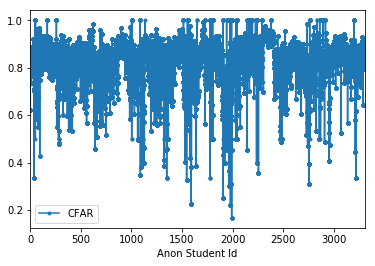

In [46]:
# Scatter Plot (Point wise)

scatter_data = data[['Anon Student Id','CFAR']]
scatter_data[['Anon Student Id','CFAR']].plot(x='Anon Student Id',y='CFAR',marker='.').figure
plt.show()
plt.close()

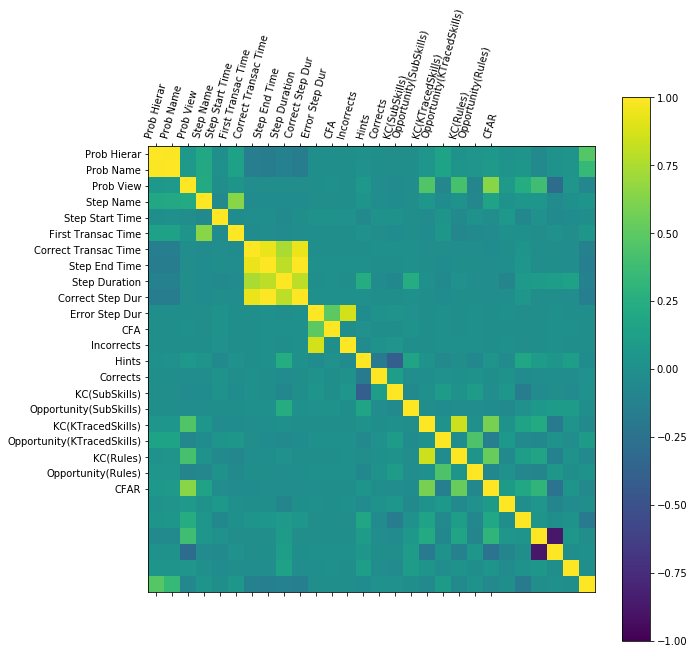

In [47]:
# Now let's create a correlation matrix. 

names = ['Prob Hierar', 'Prob Name','Prob View', 'Step Name', 'Step Start Time', 'First Transac Time', 
         'Correct Transac Time', 'Step End Time', 'Step Duration', 'Correct Step Dur', 'Error Step Dur', 
         'CFA', 'Incorrects', 'Hints', 'Corrects', 'KC(SubSkills)', 'Opportunity(SubSkills)', 'KC(KTracedSkills)', 
         'Opportunity(KTracedSkills)', 'KC(Rules)', 'Opportunity(Rules)', 'CFAR']

correlations = data.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,22,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=75)
plt.show()
plt.close()

In [48]:
# Now let's define X and Y for test-train model. 

Y = data['Correct First Attempt']
del data['Correct First Attempt']
X = data

In [49]:
# Create test and train models

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [52]:
# Using CatBoost GBM as suggested by reviewer (See Capstone Proposal Reviewer notes) 

model = CatBoostClassifier(iterations=200, learning_rate=0.1, l2_leaf_reg=20, loss_function='Logloss', max_bin=255, 
                           thread_count=4, leaf_estimation_iterations=40, ctr_leaf_count_limit=10)

model.fit(X_train, Y_train)

preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

print("class = ", preds_class)
print("proba = ", preds_proba)

print("Accuracy: ", metrics.accuracy_score(Y_test, preds_class))
print("Log Loss: ", metrics.log_loss(Y_test, preds_proba))

0:	learn: 0.4472088	total: 7.05s	remaining: 23m 22s
1:	learn: 0.3049137	total: 14.5s	remaining: 23m 55s
2:	learn: 0.2247292	total: 21.9s	remaining: 24m
3:	learn: 0.1791493	total: 29.4s	remaining: 23m 58s
4:	learn: 0.1525236	total: 36.8s	remaining: 23m 55s
5:	learn: 0.1365069	total: 44.3s	remaining: 23m 51s
6:	learn: 0.1265480	total: 51.7s	remaining: 23m 46s
7:	learn: 0.1199704	total: 59.2s	remaining: 23m 40s
8:	learn: 0.1156888	total: 1m 6s	remaining: 23m 33s
9:	learn: 0.1126399	total: 1m 13s	remaining: 23m 25s
10:	learn: 0.1114276	total: 1m 21s	remaining: 23m 19s
11:	learn: 0.1096091	total: 1m 28s	remaining: 23m 13s
12:	learn: 0.1082921	total: 1m 36s	remaining: 23m 9s
13:	learn: 0.1073626	total: 1m 44s	remaining: 23m 4s
14:	learn: 0.1066864	total: 1m 51s	remaining: 22m 58s
15:	learn: 0.1064034	total: 1m 59s	remaining: 22m 51s
16:	learn: 0.1059146	total: 2m 6s	remaining: 22m 45s
17:	learn: 0.1055480	total: 2m 14s	remaining: 22m 40s
18:	learn: 0.1052515	total: 2m 22s	remaining: 22m 33s


Catboost Results : 

- Accuracy is 0.9473119418976447
- Log Loss is 0.10263836999384292

This is pretty decent.

# Benchmark Tests

In [53]:
# Using K-NN as benchmark test.

clf = neighbors.KNeighborsClassifier(
    n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=4)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(Y_test, y_pred))
print("Log Loss: ", metrics.log_loss(Y_test, y_pred))

Accuracy:  0.872375759064056
Log Loss:  4.408074225327799


The main highlight is log-loss value. Catboost does a great job in minimising the log loss. 
Accuracy difference is significant enough. 

I am satisfied with the results. 

# Wrapping Up

Confusion Matrix, Without Normalization
[[  61400  198761]
 [  28871 1494579]]
Normalized Confusion Matrix
[[0.24 0.76]
 [0.02 0.98]]


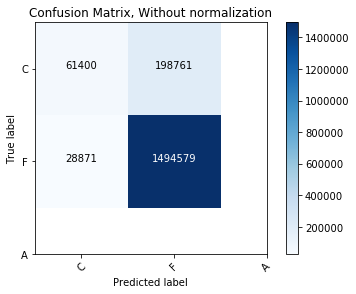

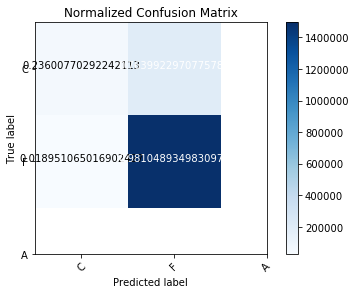

In [54]:
y_label = 'CFA'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y_label,
                      title='Confusion Matrix, Without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y_label, normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()
plt.close()

The confusion matrix is the benchmark model performance. 
The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Catboost model works way better than benchmark as shown by results. :)

Howevewer, we can still improve our model in an optimised manner :
    
- Create multi columns for both KC and Opportunity i.e. seperate these multi-columns as features.
- CFAR's NaN was assumed to be 0.5. There could other equivalent values (Example : 0). Needs careful design.
- We can explore other algorithms. GridSearch CV can help in fine-tuning hyperparameters.

I had my hardware limitations to experiment with other algorithms, however I am happy with the results! 